In [71]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from IPython.display import display, HTML
from scipy.cluster.hierarchy import dendrogram, linkage
from pandas.plotting import andrews_curves, parallel_coordinates, lag_plot, autocorrelation_plot, radviz

#import geopandas as gpd
#from shapely.geometry import Point

In [72]:
data = pd.read_csv('source/data.csv')

<font size="6">  
    Visualizations
</font> 

In [73]:
# Set up the figure size and style
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [74]:
# Ignore specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")


In [75]:
# Replace the values
data['gravity'] = data['gravity'].replace({
     0: '1 - Unknown',
     1: '1 - Unharmed',
     2: '2 - Killed',
     3: '3 - Hospitalized',
     4: '4 - Slightly injured'
})

In [76]:
# Function to calculate and display percentages
def calculate_and_display_percentages(data, group_by_col):
    counts = data.groupby([group_by_col, 'gravity']).size().reset_index(name='count')
    total_counts = data[group_by_col].value_counts().reset_index(name='total')
    total_counts.columns = [group_by_col, 'total']
    counts = counts.merge(total_counts, on=group_by_col)
    counts['percentage'] = counts['count'] / counts['total'] * 100
    
    # Pivot the table to show only percentages
    percentage_table = counts.pivot(index=group_by_col, columns='gravity', values='percentage').fillna(0)
    
    # Improve table visualization
    styled_table = percentage_table.style.format("{:.1f}%").set_table_styles(
        [{'selector': 'th', 'props': [('font-size', '12pt'), ('font-weight', 'bold'), ('text-align', 'center')]},
         {'selector': 'td', 'props': [('font-size', '10pt'), ('text-align', 'center')]},
         {'selector': 'caption', 'props': [('caption-side', 'top')]}]
    ).set_caption(f'Percentages of Accident Gravity by {group_by_col.capitalize()}').background_gradient(cmap='Blues', axis=None)
    
    # Display the styled table
    html = styled_table.to_html()
    display(HTML(html))

In [77]:
data.head()

,AccID,day,month,year,time,lum,dep_code,com_code,location,int,...,age,vehicleID_y,num_veh_y,traffic_direction,vehicle_category,fixed_obstacle,mobile_obstacle,initial_impact_point,manv,motor
0,201900000001,30,11,2019,01:30:00,4,93,93053,1,1,...,22,138 306 524,B01,2,7,0,2,5,23,1
1,201900000001,30,11,2019,01:30:00,4,93,93053,1,1,...,22,138 306 525,A01,2,17,1,0,3,11,1
2,201900000001,30,11,2019,01:30:00,4,93,93053,1,1,...,31,138 306 524,B01,2,7,0,2,5,23,1
3,201900000001,30,11,2019,01:30:00,4,93,93053,1,1,...,31,138 306 525,A01,2,17,1,0,3,11,1
4,201900000001,30,11,2019,01:30:00,4,93,93053,1,1,...,65,138 306 524,B01,2,7,0,2,5,23,1


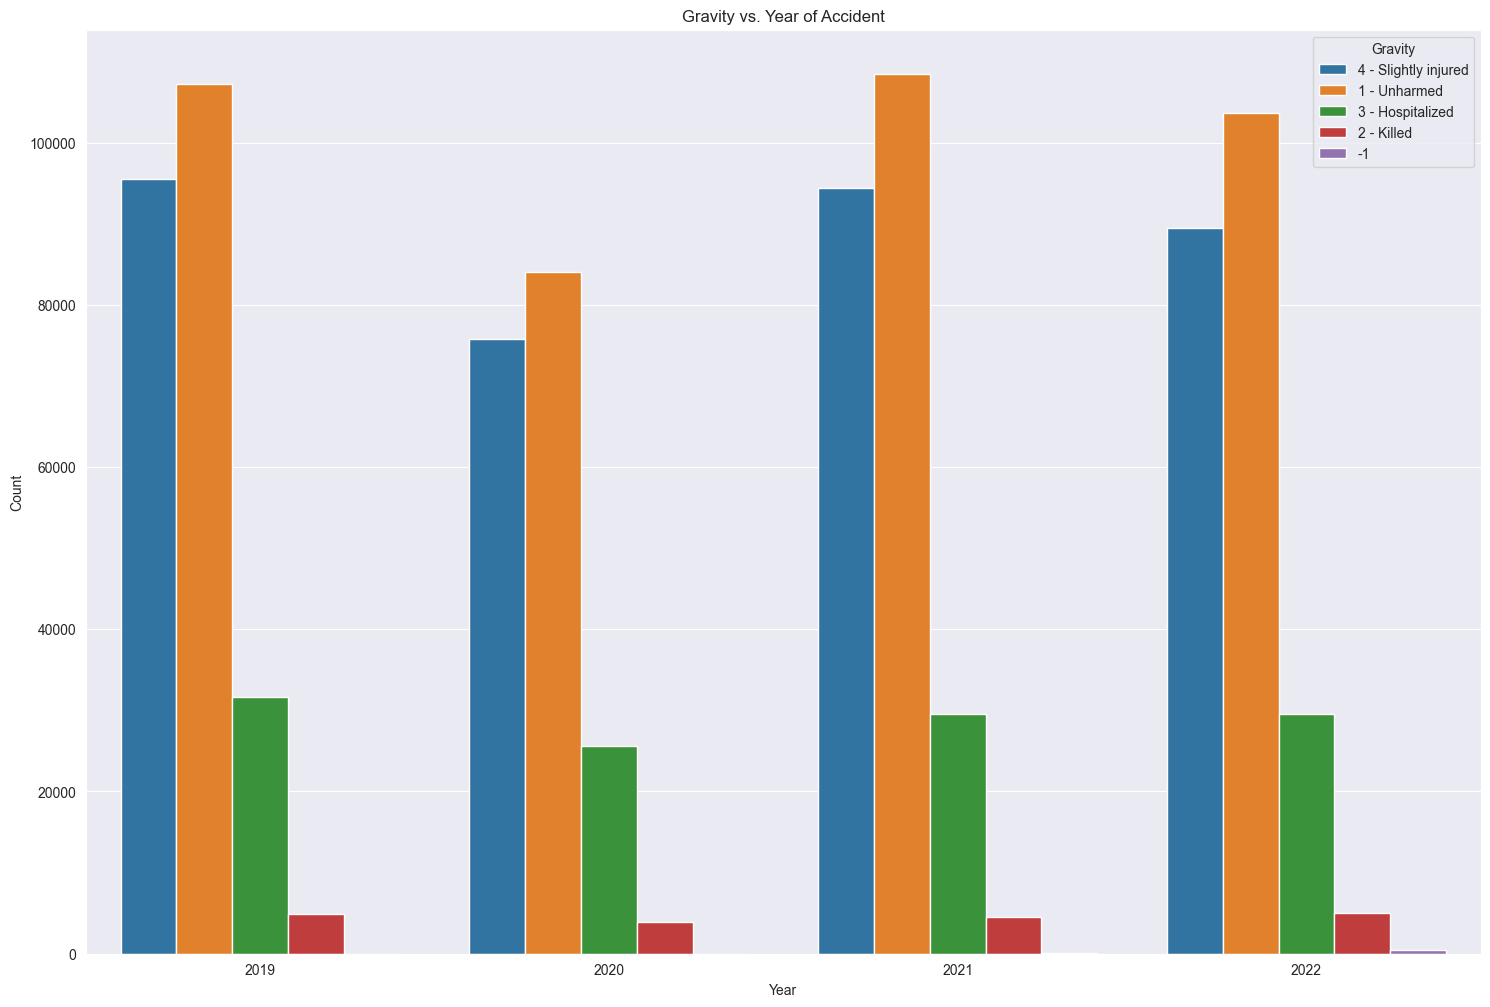

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
year,,,,,
2019,0.0%,44.8%,2.0%,13.2%,39.9%
2020,0.0%,44.4%,2.0%,13.5%,40.0%
2021,0.0%,45.8%,1.9%,12.4%,39.8%
2022,0.2%,45.4%,2.2%,12.9%,39.2%


In [78]:
# Gravity vs. Year
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='year', hue='gravity')
plt.title('Gravity vs. Year of Accident')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.show()

# Gravity vs. Year
calculate_and_display_percentages(data, 'year')


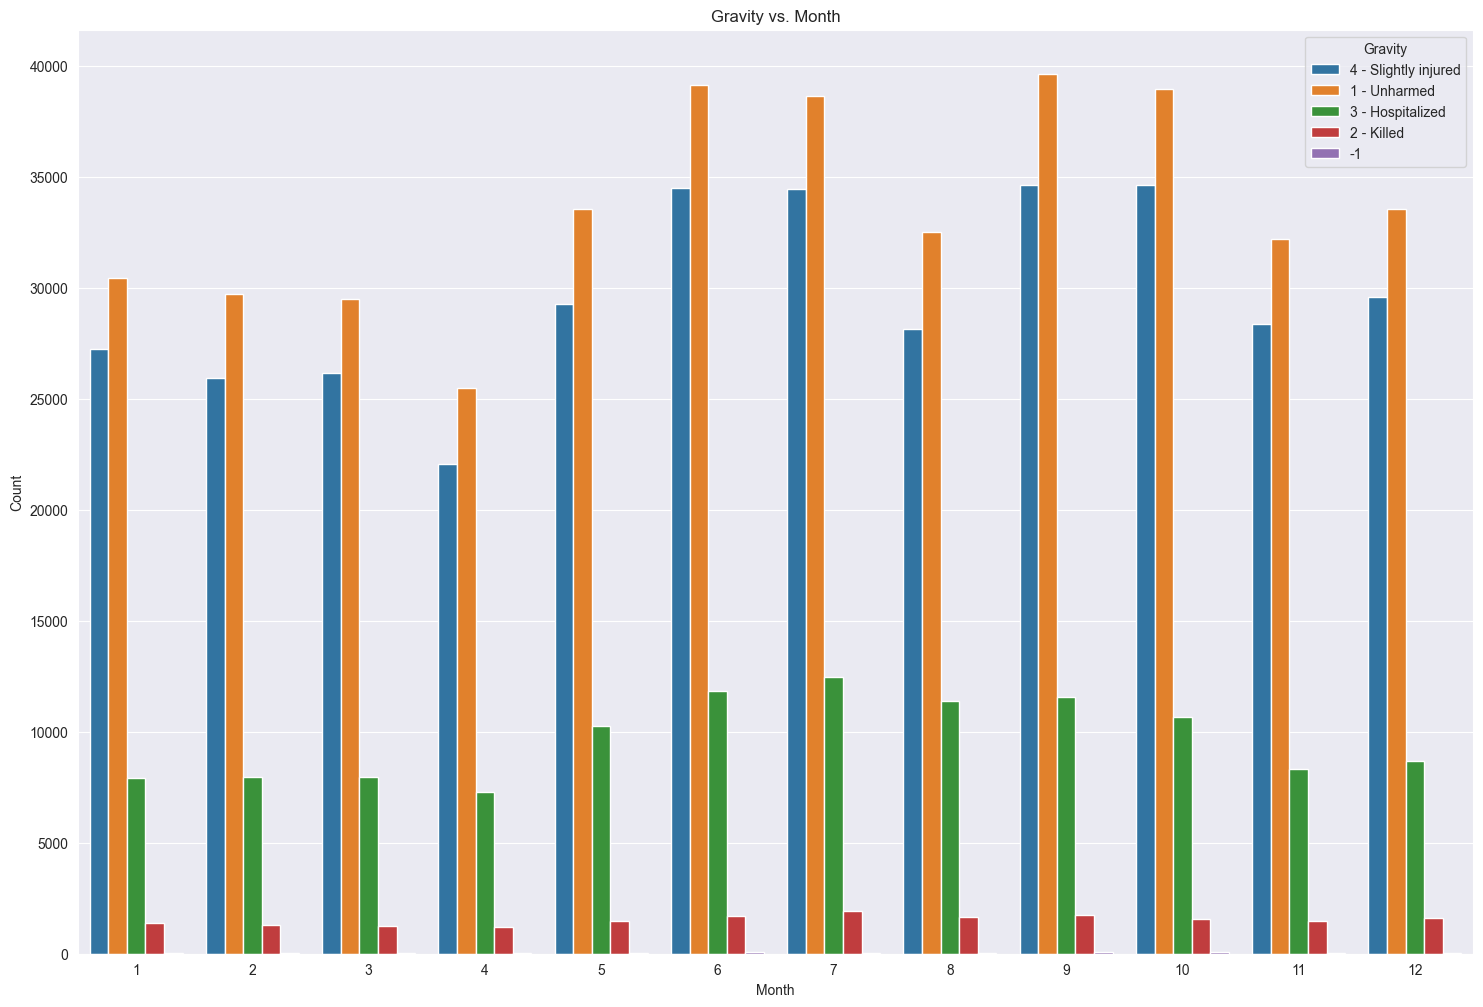

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
month,,,,,
1,0.0%,45.4%,2.1%,11.8%,40.7%
2,0.1%,45.8%,2.0%,12.3%,39.9%
3,0.1%,45.4%,1.9%,12.2%,40.3%
4,0.0%,45.5%,2.2%,13.0%,39.4%
5,0.0%,45.0%,2.0%,13.8%,39.2%
6,0.1%,44.9%,2.0%,13.5%,39.5%
7,0.1%,44.2%,2.2%,14.2%,39.4%
8,0.0%,44.1%,2.3%,15.4%,38.2%
9,0.1%,45.2%,2.0%,13.2%,39.5%


In [79]:
# Gravity vs. Month
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='month', hue='gravity')
plt.title('Gravity vs. Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.show()

# Gravity vs. Month
calculate_and_display_percentages(data, 'month')

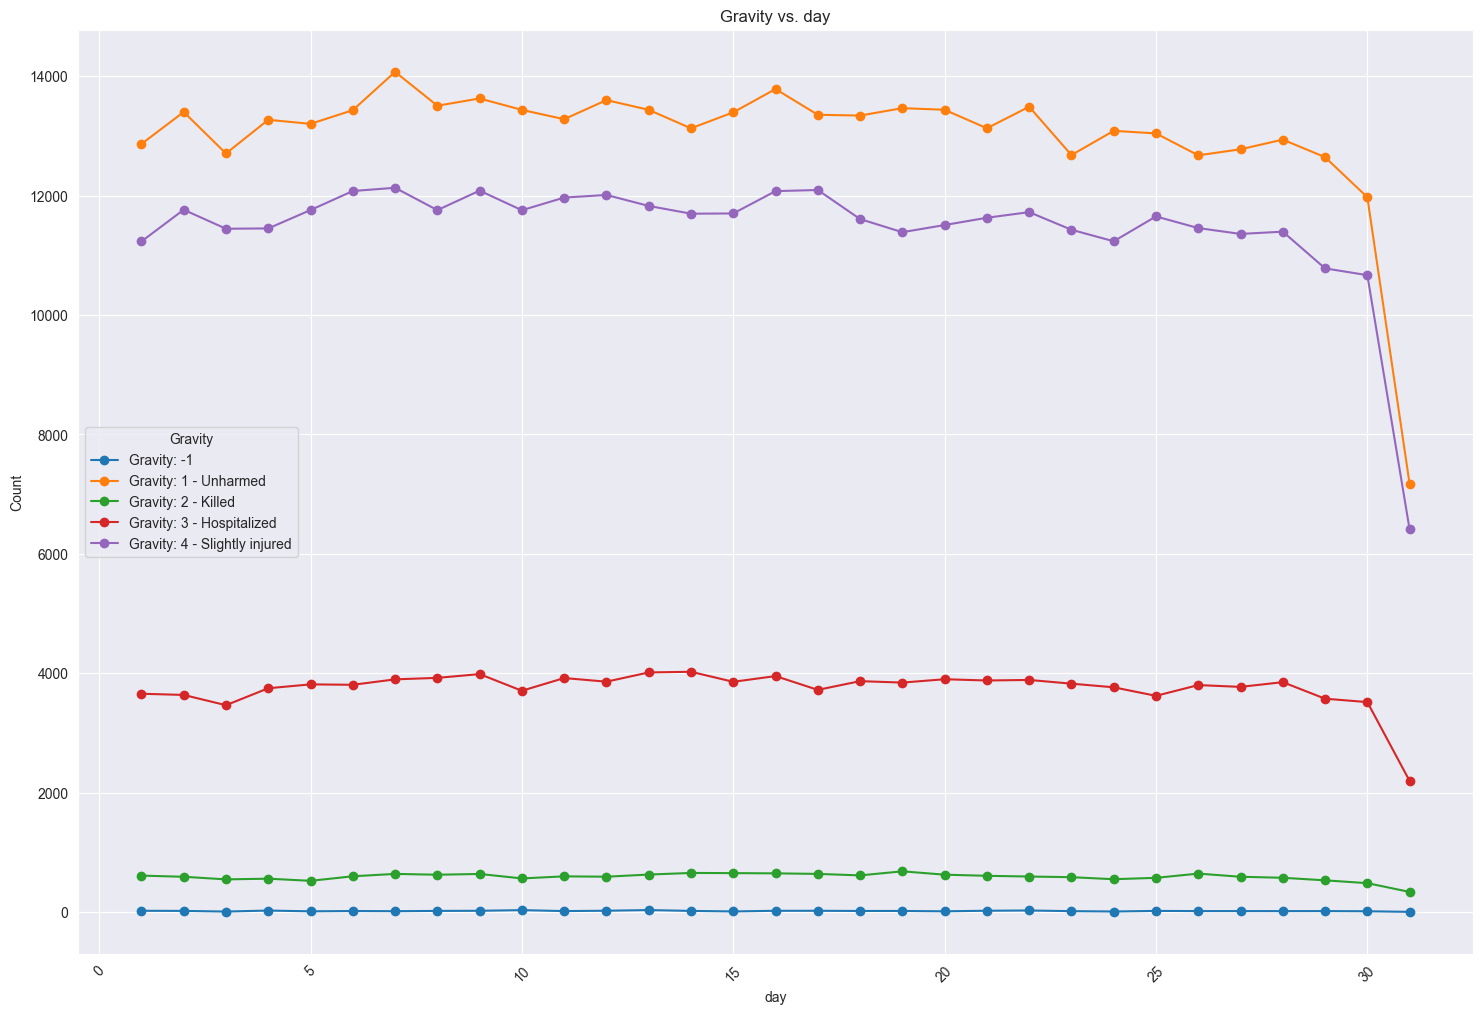

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
day,,,,,
1,0.1%,45.3%,2.1%,12.9%,39.6%
2,0.1%,45.6%,2.0%,12.4%,40.0%
3,0.0%,45.1%,1.9%,12.3%,40.6%
4,0.1%,45.7%,1.9%,12.9%,39.4%
5,0.0%,45.0%,1.8%,13.0%,40.1%
6,0.1%,44.9%,2.0%,12.7%,40.4%
7,0.0%,45.8%,2.1%,12.7%,39.4%
8,0.1%,45.3%,2.1%,13.1%,39.4%
9,0.1%,44.9%,2.1%,13.1%,39.8%


In [80]:
# Aggregate the data by vehicle_category and gravity
agg_dataday = data.groupby(['day', 'gravity']).size().unstack(fill_value=0)

# Gravity vs. Day
plt.figure(figsize=(18, 12))
for gravity in agg_dataday.columns:
    plt.plot(agg_dataday.index, agg_dataday[gravity], marker='o', label=f'Gravity: {gravity}')

plt.title('Gravity vs. day')
plt.xlabel('day')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Gravity vs. Day
calculate_and_display_percentages(data, 'day')

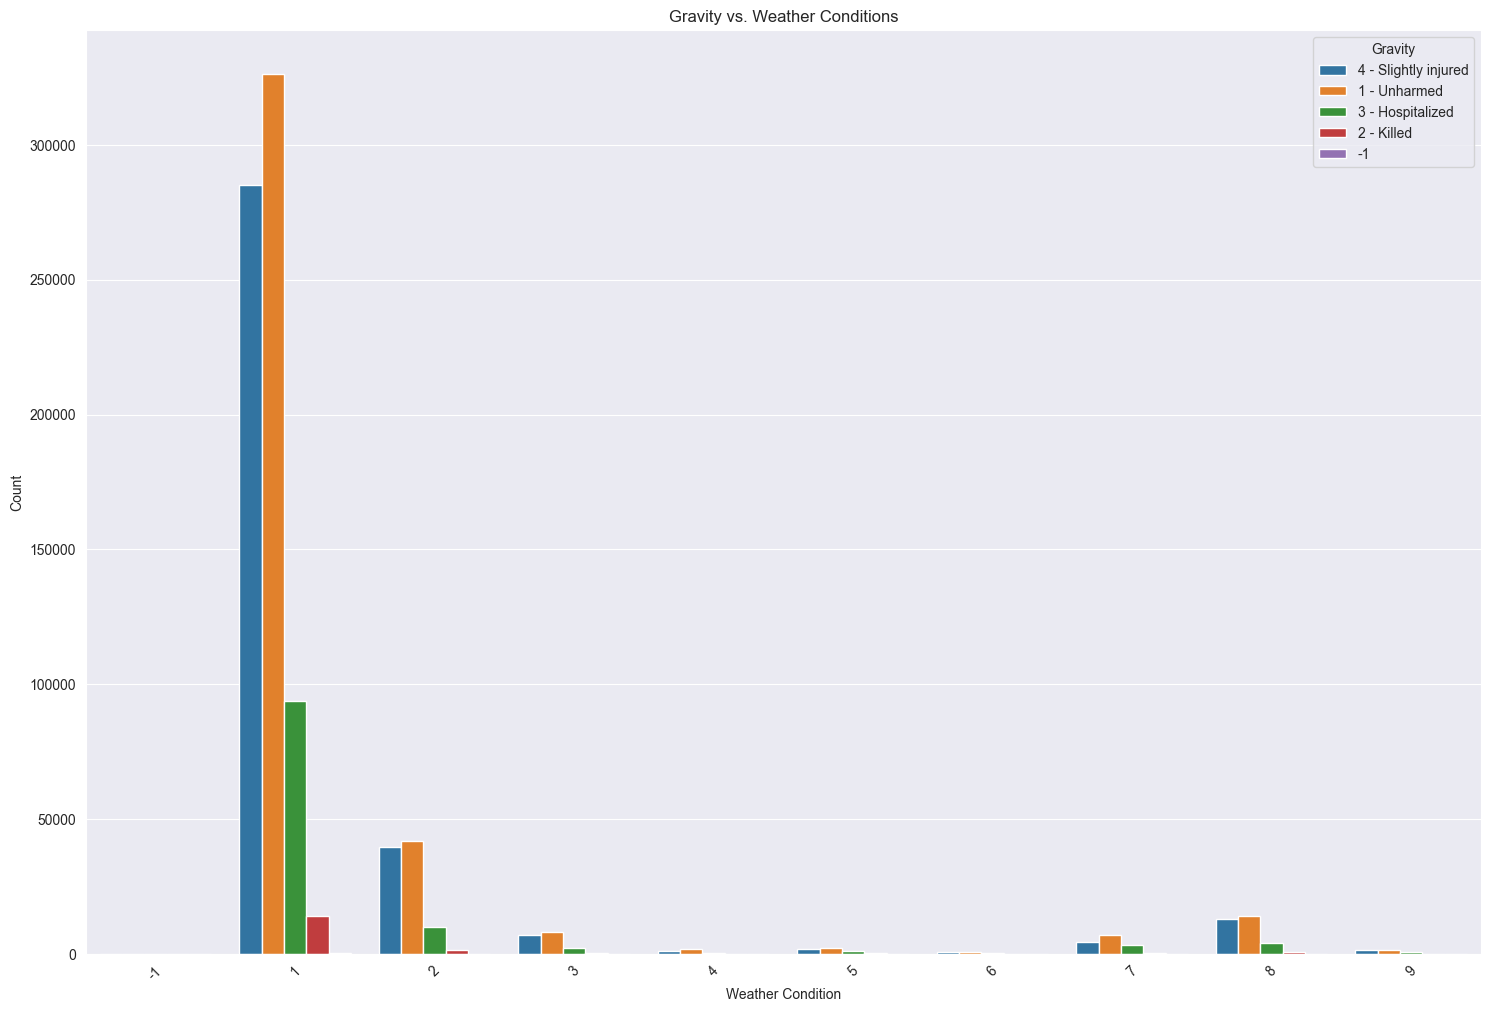

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
atm_condition,,,,,
-1,0.0%,35.3%,5.9%,11.8%,47.1%
1,0.1%,45.3%,2.0%,13.0%,39.6%
2,0.1%,44.7%,1.8%,10.9%,42.5%
3,0.0%,44.5%,2.2%,13.4%,39.9%
4,0.1%,51.7%,2.2%,12.5%,33.5%
5,0.1%,38.6%,4.9%,19.9%,36.4%
6,0.0%,36.4%,4.0%,23.9%,35.7%
7,0.0%,46.3%,3.0%,20.7%,29.9%
8,0.0%,44.1%,2.6%,12.4%,40.9%


In [81]:
# Gravity vs. Weather Conditions (atm_condition)
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='atm_condition', hue='gravity')
plt.title('Gravity vs. Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

# Gravity vs. Weather Conditions (atm_condition)
calculate_and_display_percentages(data, 'atm_condition')

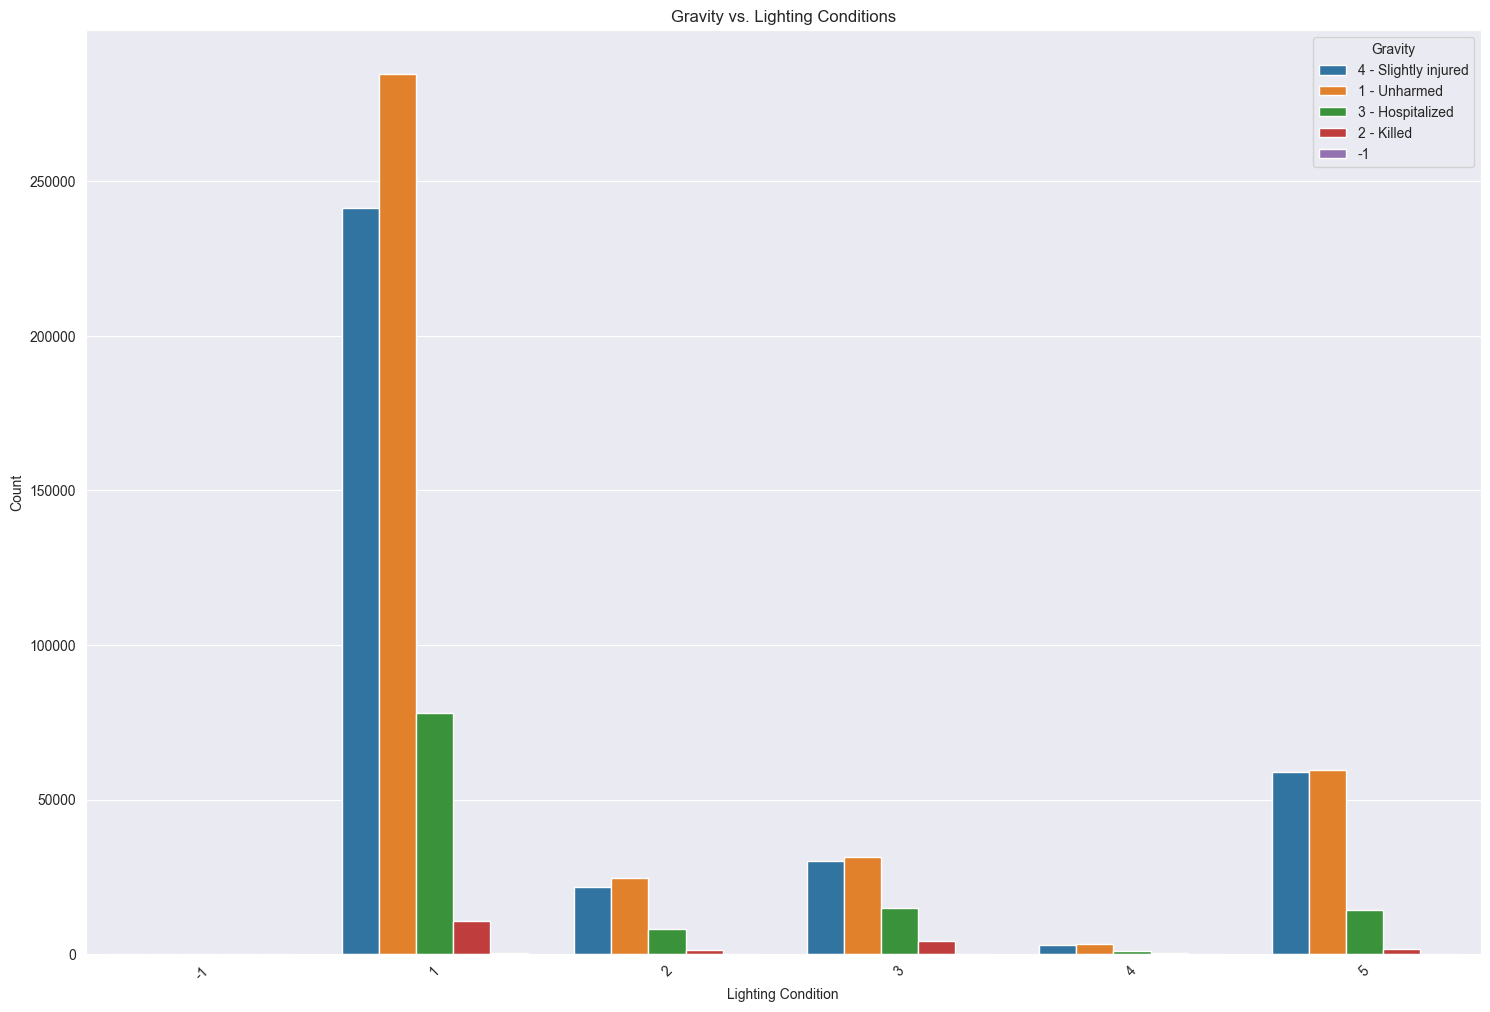

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
lum,,,,,
-1,0.0%,50.0%,0.0%,0.0%,50.0%
1,0.1%,46.3%,1.8%,12.7%,39.2%
2,0.0%,43.8%,2.4%,14.8%,39.0%
3,0.0%,39.1%,5.2%,18.5%,37.3%
4,0.1%,42.7%,3.0%,13.2%,41.0%
5,0.1%,44.3%,1.3%,10.5%,43.7%


In [82]:
# Gravity vs. Lighting Conditions (lum)
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='lum', hue='gravity')
plt.title('Gravity vs. Lighting Conditions')
plt.xlabel('Lighting Condition')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

# Gravity vs. Lighting Conditions (lum)
calculate_and_display_percentages(data, 'lum')

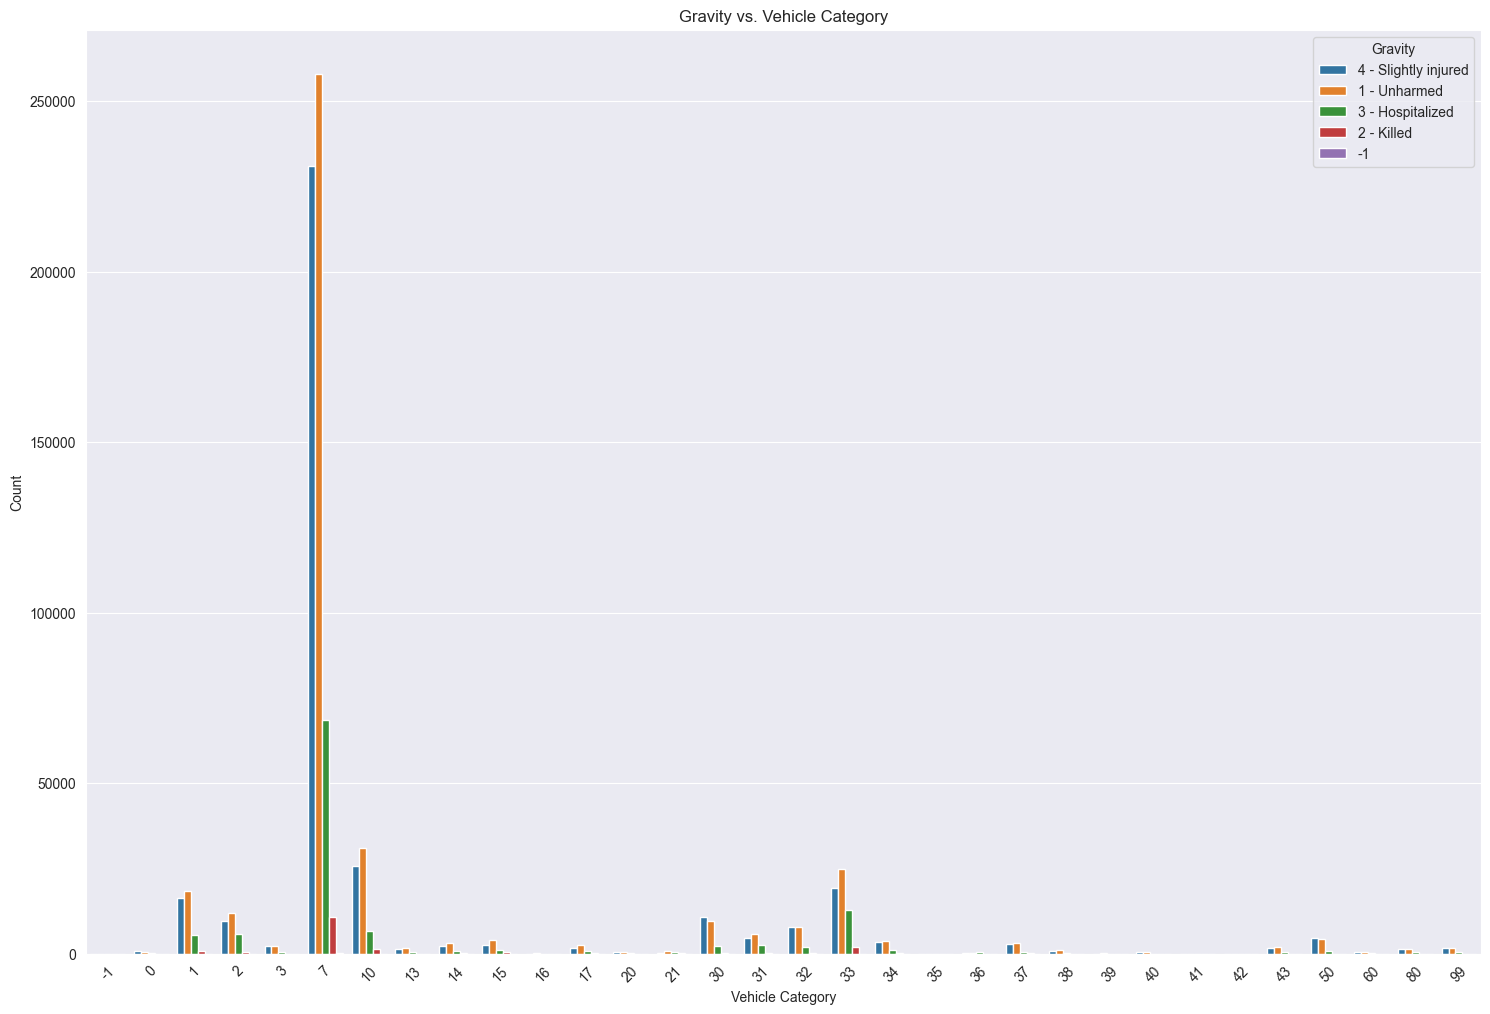

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
vehicle_category,,,,,
-1,0.0%,44.0%,12.0%,16.0%,28.0%
0,2.8%,36.4%,2.5%,14.5%,43.8%
1,0.1%,44.5%,2.0%,13.5%,39.9%
2,0.1%,43.3%,1.6%,21.0%,34.1%
3,0.2%,43.9%,1.8%,12.1%,42.1%
7,0.1%,45.4%,1.9%,12.1%,40.6%
10,0.1%,48.0%,2.0%,10.4%,39.5%
13,0.2%,47.3%,2.7%,12.5%,37.2%
14,0.0%,49.0%,5.4%,12.3%,33.3%


In [83]:
# Gravity vs. Vehicle Category
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='vehicle_category', hue='gravity')
plt.title('Gravity vs. Vehicle Category')
plt.xlabel('Vehicle Category')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

# Gravity vs. Vehicle Category
calculate_and_display_percentages(data, 'vehicle_category')

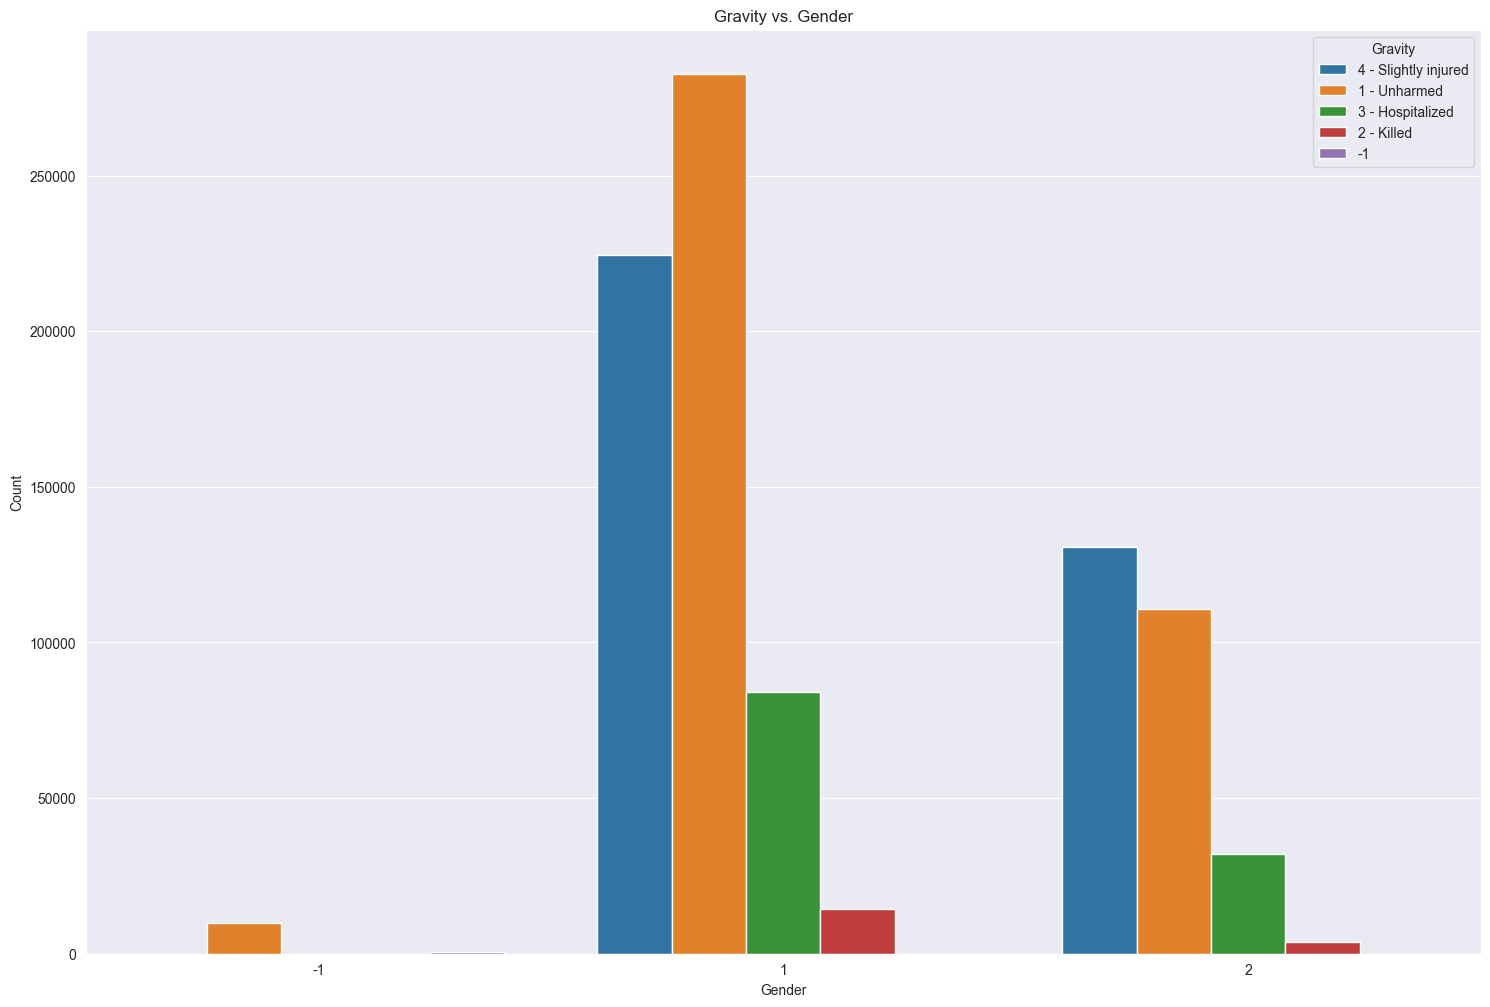

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
gender,,,,,
-1,5.2%,94.8%,0.0%,0.0%,0.0%
1,0.0%,46.7%,2.4%,13.9%,37.1%
2,0.0%,39.9%,1.4%,11.6%,47.1%


In [84]:
# Gravity vs. Gender
plt.figure(figsize=(18, 12))
sns.countplot(data=data, x='gender', hue='gravity')
plt.title('Gravity vs. Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.show()

# Gravity vs. Gender
calculate_and_display_percentages(data, 'gender')

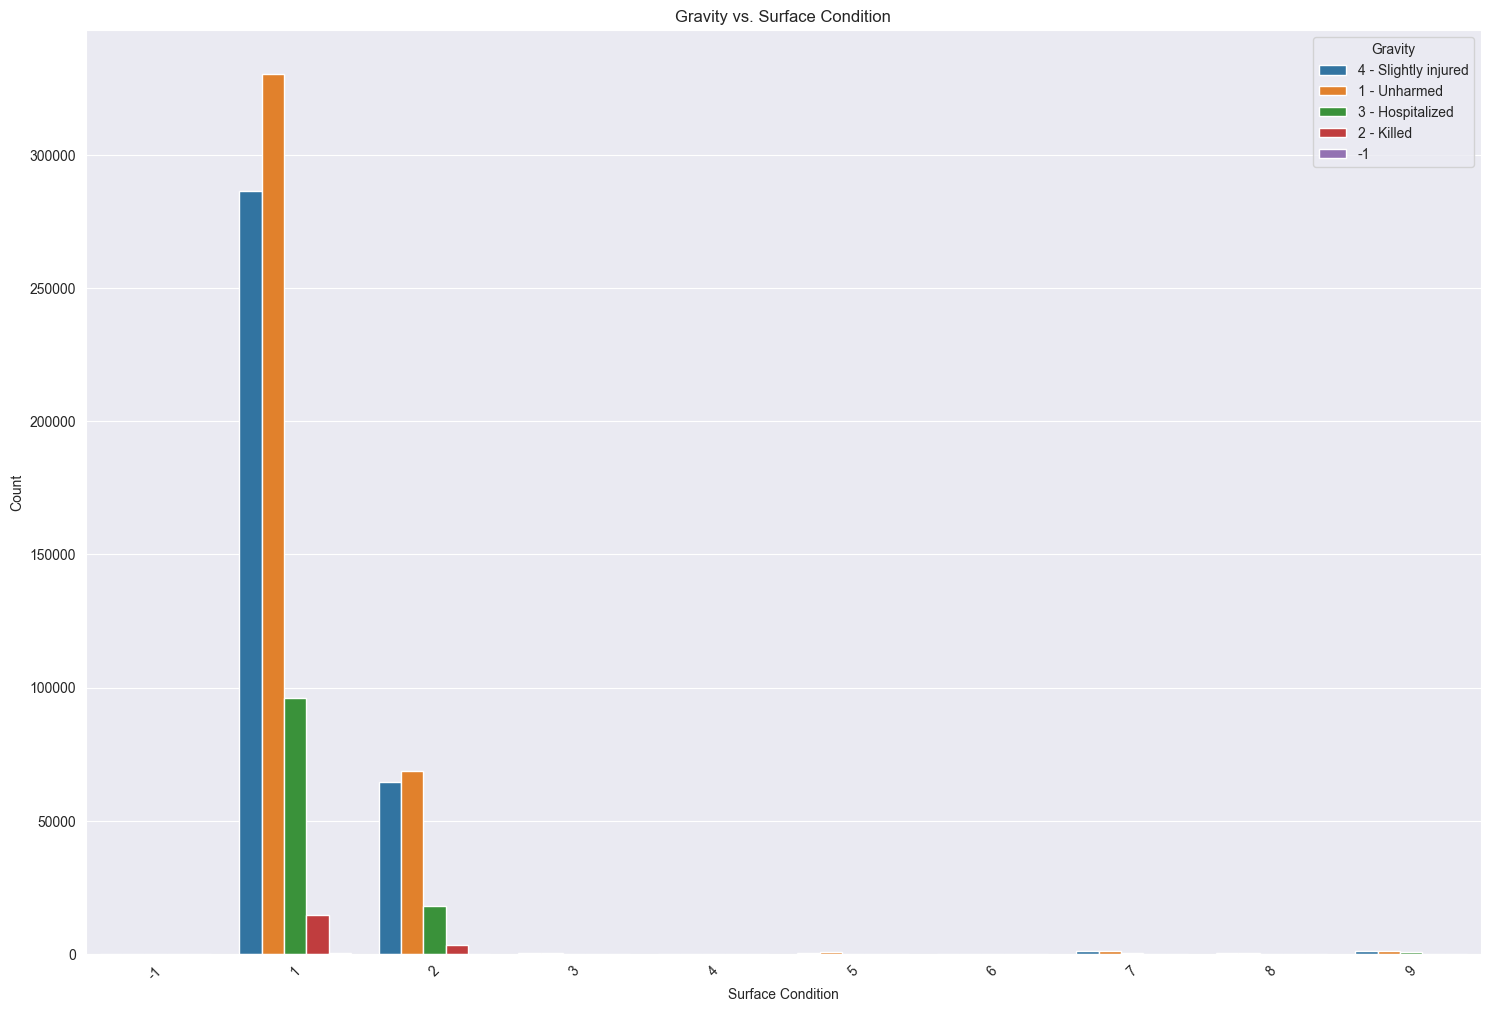

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
surface_condition,,,,,
-1,0.0%,46.9%,12.5%,6.2%,34.4%
1,0.1%,45.4%,2.0%,13.2%,39.4%
2,0.0%,44.3%,2.2%,11.7%,41.7%
3,0.0%,43.8%,2.3%,16.4%,37.5%
4,0.0%,42.3%,3.7%,15.6%,38.3%
5,0.3%,49.2%,2.1%,13.4%,35.0%
6,0.0%,28.4%,5.2%,30.3%,36.2%
7,0.1%,37.1%,4.3%,20.7%,37.8%
8,0.0%,40.1%,1.3%,16.9%,41.8%


In [85]:
# Gravity vs. Surface Condition
plt.figure(figsize=(18,12))
sns.countplot(data=data, x='surface_condition', hue='gravity')
plt.title('Gravity vs. Surface Condition')
plt.xlabel('Surface Condition')
plt.ylabel('Count')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

# Gravity vs. Surface Condition
calculate_and_display_percentages(data, 'surface_condition')

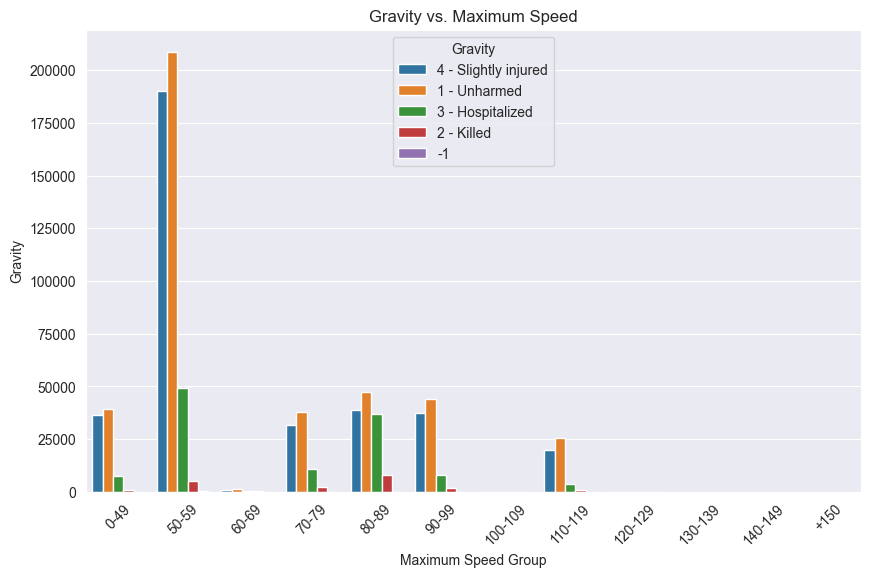

gravity,-1,1 - Unharmed,2 - Killed,3 - Hospitalized,4 - Slightly injured
maximum_speed,,,,,
6,3.6%,41.8%,0.0%,10.9%,43.6%
7,0.0%,54.5%,0.0%,18.2%,27.3%
8,0.0%,0.0%,0.0%,0.0%,100.0%
9,0.0%,66.7%,0.0%,0.0%,33.3%
10,0.0%,46.5%,2.2%,11.8%,39.5%
12,0.0%,62.5%,0.0%,0.0%,37.5%
15,0.0%,46.1%,1.0%,9.9%,43.1%
20,0.1%,43.5%,1.6%,13.3%,41.6%
25,0.0%,37.5%,0.4%,5.8%,56.2%


In [86]:
# Define the bins and corresponding labels
bins = [0, 49, 59, 69, 79, 89, 99, 109, 119, 129, 139, 149, float('inf')]
labels = ['0-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100-109', '110-119', '120-129', '130-139', '140-149', '+150']

# Create a new column for the binned speeds
data['speed_group'] = pd.cut(data['maximum_speed'], bins=bins, labels=labels, right=False)

# Gravity vs. Maximum Speed
plt.figure(figsize=(10, 6))
#sns.scatterplot(data=data, x='speed_group', y='gravity', hue='gravity', palette='viridis')
sns.countplot(data=data, x='speed_group', hue='gravity')

plt.title('Gravity vs. Maximum Speed')
plt.xlabel('Maximum Speed Group')
plt.ylabel('Gravity')
plt.legend(title='Gravity')
plt.xticks(rotation=45)
plt.show()

# Gravity vs. Maximum Speed
calculate_and_display_percentages(data, 'maximum_speed')

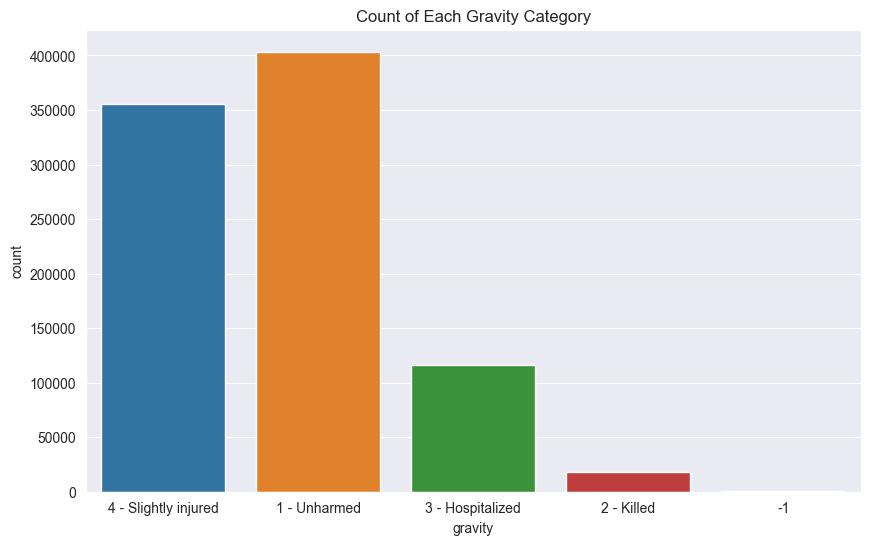

In [88]:
# 1. Bar Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='gravity')
plt.title('Count of Each Gravity Category')
plt.show()

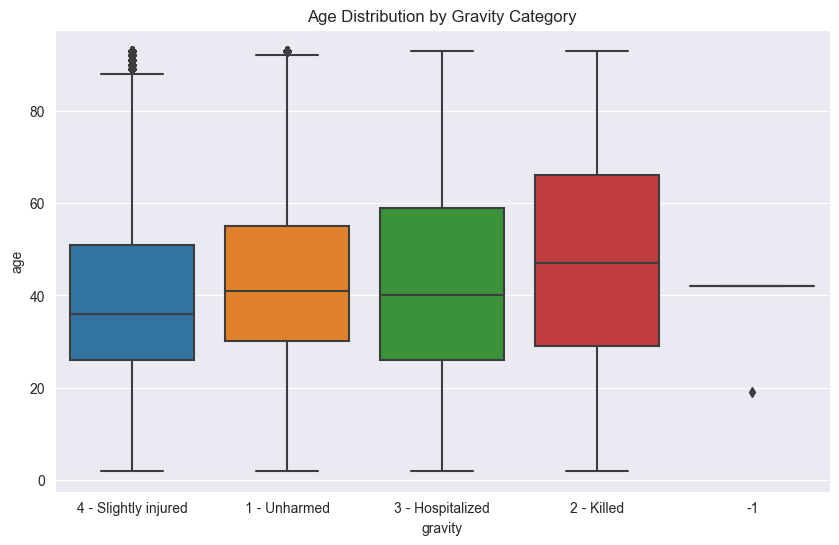

In [89]:
# 2. Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, x='gravity', y='age')
plt.title('Age Distribution by Gravity Category')
plt.show()

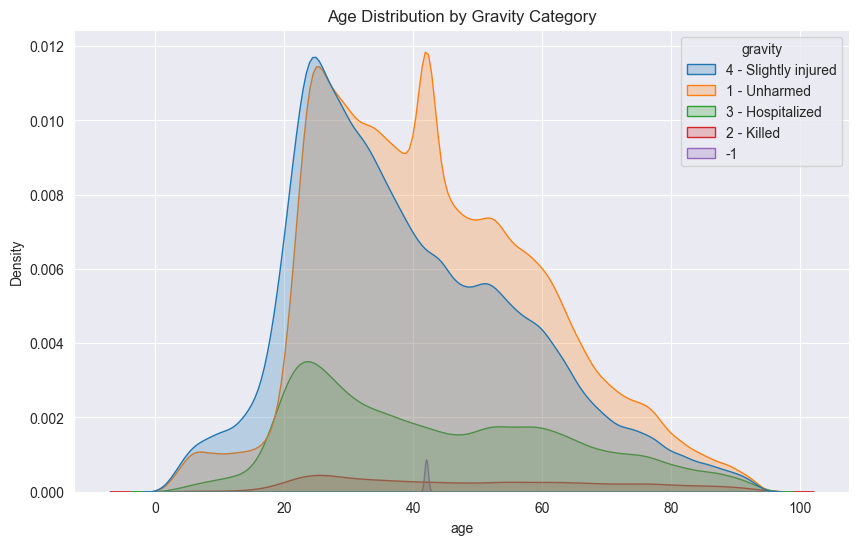

In [92]:
# 5. KDE Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='age', hue='gravity', fill=True)
plt.title('Age Distribution by Gravity Category')
plt.show()

In [ ]:
# 6. Pair Plot
sns.pairplot(data, hue='gravity', diag_kind='kde')
plt.show()

In [ ]:
# 7. Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()